In [ ]:
!pip install llama-index
!pip install llama-index-vector-stores-qdrant llama-index-embeddings-fastembed
!pip install llama-index-readers-file
!pip install llama-index-llms-groq  # deepseek r1

In [1]:
import logging
import sys
import os

In [3]:
import qdrant_client
from qdrant_client import models
from llama_index.core import SimpleDirectoryReader
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.llms.groq import Groq # deep seek r1 implementation

## Load the source documents - Bhagavad Gita PDF

In [4]:
data = SimpleDirectoryReader("data").load_data()

In [5]:
len(data)

892

In [7]:
data[100].text

'the\tAbsolute\tTruth.\tAnd\tthe\tstudent\twho\tcan\tenter\tinto\tthe\theart\tof\tthe\tsun\nplanet\t is\t compared\t to\t those\t who\t realize\t the\t personal\t features\t of\t the\nSupreme\t Absolute\t Truth.\t Therefore,\t the\tbhaktas,\tor\t the\t transcendentalists\nwho\t have\t realized\t the\t Bhagavān\t feature\t of\t the\t Absolute\t Truth,\t are\t the\ntopmost\t transcendentalists,\t although\t all\t students\t who\t are\t engaged\t in\t the\nstudy\t of\t the\t Absolute\t Truth\t are\t engaged\t in\t the\t same\t subject\t matter.\t The\nsunshine,\t the\t sun\t disc\t and\t the\t inner\t affairs\t of\t the\t sun\t planet\t cannot\t be\nseparated\t from\t one\t another,\t and\t yet\t the\t students\t of\t the\t three\t different\nphases\tare\tnot\tin\tthe\tsame\tcategory.\nThe\t Sanskrit\t word\t Bhagavān\t is\t explained\t by\t the\t great\t authority,\nParāśara\t Muni,\t the\t father\t of\t Vyāsadeva.\t The\t Supreme\t Personality\t who\npossesses\tall\triches,\tall\tstreng

In [8]:
texts = [doc.text for doc in data]

In [9]:
texts[100]

'the\tAbsolute\tTruth.\tAnd\tthe\tstudent\twho\tcan\tenter\tinto\tthe\theart\tof\tthe\tsun\nplanet\t is\t compared\t to\t those\t who\t realize\t the\t personal\t features\t of\t the\nSupreme\t Absolute\t Truth.\t Therefore,\t the\tbhaktas,\tor\t the\t transcendentalists\nwho\t have\t realized\t the\t Bhagavān\t feature\t of\t the\t Absolute\t Truth,\t are\t the\ntopmost\t transcendentalists,\t although\t all\t students\t who\t are\t engaged\t in\t the\nstudy\t of\t the\t Absolute\t Truth\t are\t engaged\t in\t the\t same\t subject\t matter.\t The\nsunshine,\t the\t sun\t disc\t and\t the\t inner\t affairs\t of\t the\t sun\t planet\t cannot\t be\nseparated\t from\t one\t another,\t and\t yet\t the\t students\t of\t the\t three\t different\nphases\tare\tnot\tin\tthe\tsame\tcategory.\nThe\t Sanskrit\t word\t Bhagavān\t is\t explained\t by\t the\t great\t authority,\nParāśara\t Muni,\t the\t father\t of\t Vyāsadeva.\t The\t Supreme\t Personality\t who\npossesses\tall\triches,\tall\tstreng

In [10]:
len(texts)

892

In [11]:
from google.colab import userdata

In [12]:
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [13]:
llm = Groq(model="deepseek-r1-distill-llama-70b")

In [ ]:
llm.complete("what is the meaning of life?").text

In [16]:
embed_model = FastEmbedEmbedding(model_name="thenlper/gte-large")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

In [18]:
client = qdrant_client.QdrantClient(
    #location=":memory:",
    url = userdata.get("QDRANT_URL"),
    api_key = userdata.get("QDRANT_API_KEY"),
    prefer_grpc=True
)

In [19]:
collection_name = "bhagavad-gita"

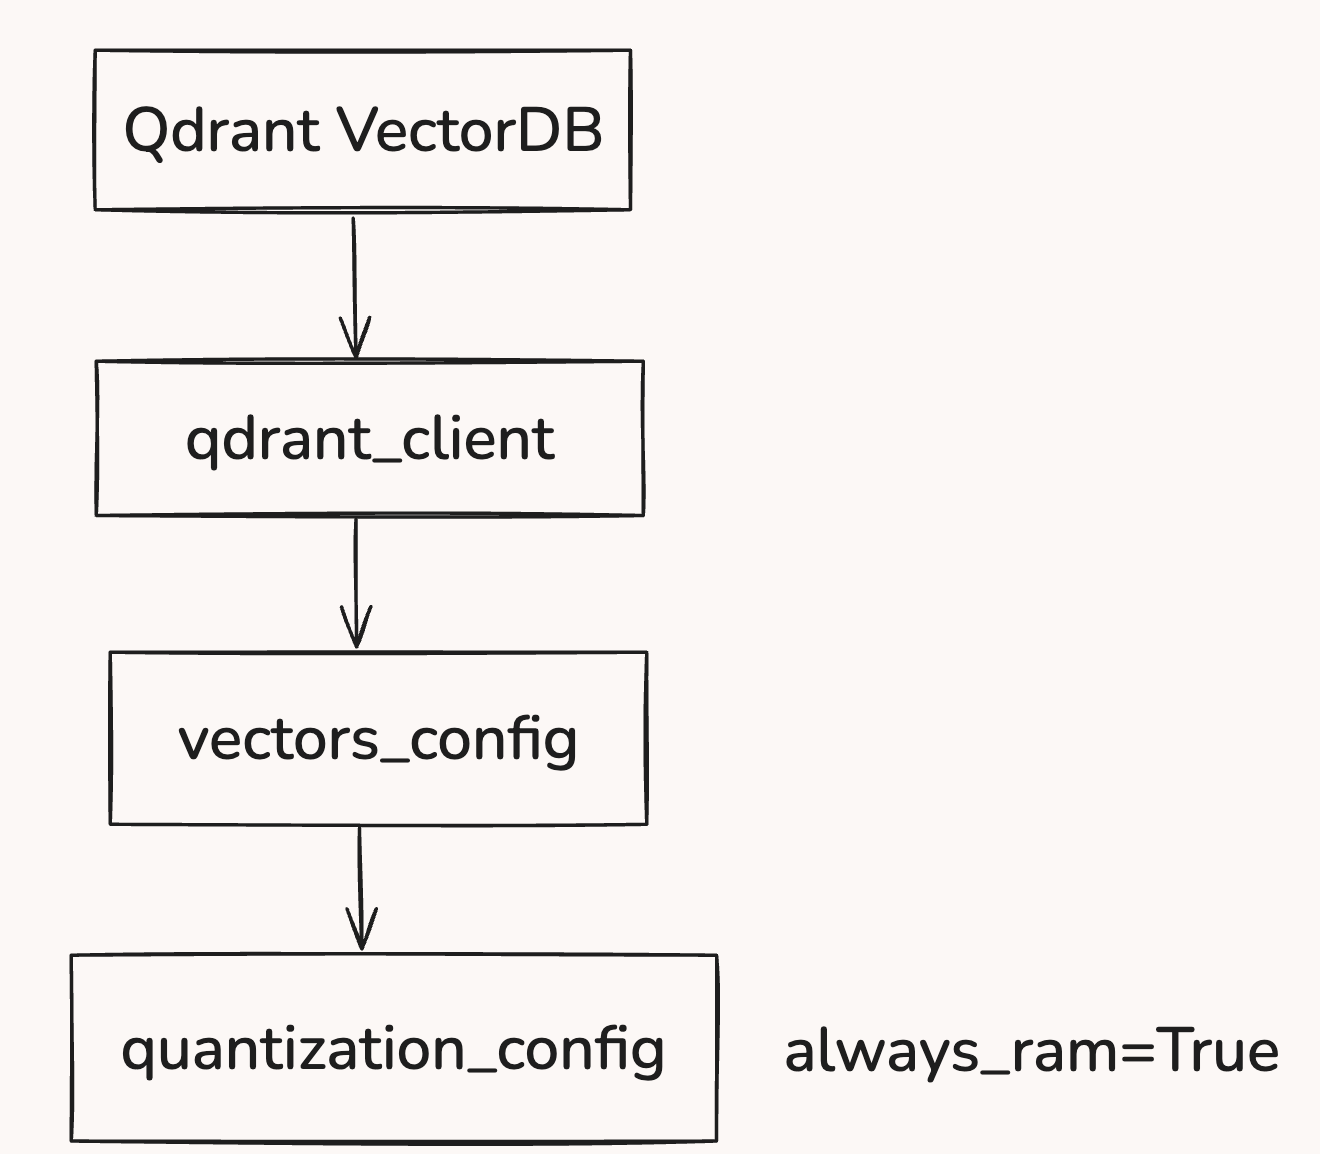

In [20]:
if not client.collection_exists(collection_name=collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=1024,
                                           distance=models.Distance.COSINE,on_disk=True),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    )
else:
    print("Collection already exists")

Collection already exists


In [ ]:
embeddings = []
BATCH_SIZE = 50

In [24]:
for page in range(0, len(texts), BATCH_SIZE):
    page_content = texts[page:page + BATCH_SIZE]
    response = embed_model.get_text_embedding_batch(page_content)
    embeddings.extend(response)

In [28]:
for idx in range(0, len(texts), BATCH_SIZE):
    docs = texts[idx:idx + BATCH_SIZE]
    embeds = embeddings[idx:idx + BATCH_SIZE]

    client.upload_collection(collection_name=collection_name,
                                vectors=embeds,
                                payload=[{"context": context} for context in docs])

In [29]:
client.update_collection(collection_name= collection_name,
                        optimizer_config=models.OptimizersConfigDiff(indexing_threshold=20000))

True

## Retrieval Augmented Generation

In [21]:
def search(query,k=5):
  # query = user prompt
  query_embedding = embed_model.get_query_embedding(query)
  result = client.query_points(
            collection_name = collection_name,
            query=query_embedding,
            limit = k
        )
  return result

In [22]:
relevant_docs = search("In Bhagavad-gītā who is the person devoted to?")

In [28]:
len(relevant_docs.points)

5

In [26]:
print(relevant_docs.points[4].payload['context'])

But	 within	 all	 these	 activities,	 the	 important	 factor	 is	 self-realization.	 One
who	seeks	that	objective	is	the	real	student	of	 Bhagavad-gītā,	but	one	who
doubts	the	authority	of	Kṛṣṇa	falls	back.	One	is	therefore	advised	to	study
Bhagavad-gītā,	or	 any	 other	 scripture,	 under	 a	 bona	 fide	 spiritual	 master,
with	service	and	surrender.	A	bona	fide	spiritual	master	is	in	the	disciplic
succession	 from	 time	 eternal,	 and	 he	 does	 not	 deviate	 at	 all	 from	 the
instructions	 of	 the	 Supreme	 Lord	 as	 they	 were	 imparted	 millions	 of	 years
ago	 to	 the	 sun-god,	 from	 whom	 the	 instructions	 of	Bhagavad-gītā	 have
come	down	to	the	earthly	kingdom.	One	should,	therefore,	follow	the	path
of	Bhagavad-gītā	as	 it	 is	 expressed	 in	 the	Gītā	itself	 and	 beware	 of	 self-
interested	people	after	personal	aggrandizement	who	deviate	others	from	the
actual	path.	The	Lord	is	definitely	the	supreme	person,	and	His	activities	are
transcendental.	One	who	understands	this	i

In [31]:
from llama_index.core import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

message_templates = [
    ChatMessage(
        content="""
        You are an expert ancient assistant who is well verse in Bhagavad-gita.
        You are Multilingual, you understand English, Hindi and Sanskrit.
        """,
        role=MessageRole.SYSTEM),
    ChatMessage(
        content="""
        We have provided context information below.
        {context_str}
        ---------------------
        Given this information, please answer the question: {query}
        ---------------------
        If the question is not from the provided context, say `I don't know. Not enough information recieved.`
        """,
        role=MessageRole.USER,
    ),
]

In [32]:
def pipeline(query):
    # R - Retriver
    relevant_documents = search(query)
    context = [doc.payload['context'] for doc in relevant_documents.points]
    context = "\n".join(context)

    # A - Augment
    chat_template = ChatPromptTemplate(message_templates=message_templates)

    # G - Generate
    response = llm.complete(
        chat_template.format(
            context_str=context,
            query=query)
    )
    return response

In [33]:
print(pipeline("""what is the PURPORT of O	 my	 teacher,	 behold	 the	 great	 army	 of	 the	 sons	 of	 Pāṇḍu,	 so
expertly	arranged	by	your	intelligent	disciple,	the	son	of	Drupada."""))

<think>
Okay, so I need to figure out the purport of the given verse from the Bhagavad-gita. The verse is: "O my teacher, behold the great army of the sons of Pāṇḍu, so expertly arranged by your intelligent disciple, the son of Drupada." 

First, I should recall the context of this verse. It's from the Bhagavad-gita, which is a dialogue between Prince Arjuna and Lord Krishna on the eve of a great battle. Arjuna is seeing the opposing army and is conflicted about fighting his own kin. 

The verse mentions the sons of Pāṇḍu, which are the Pāṇḍavas, including Arjuna himself. The army is arranged by the son of Drupada, who is Dhṛṣṭadyumna. I remember that Dhṛṣṭadyumna was born to kill Droṇācārya, the teacher of both the Pāṇḍavas and the Kauravas. 

Droṇācārya is the teacher being addressed here. The speaker is Duryodhana, the leader of the Kauravas, who is pointing out that Droṇācārya's own student, Dhṛṣṭadyumna, is now opposing him. This might be a tactic to unsettle Droṇācārya, making hi

In [34]:
print(pipeline("""
Jayas	tu	pāṇḍu-putrāṇāṁ	yeṣāṁ	pakṣe	janārdanaḥ.
explain this gita from translation
"""))

<think>
Okay, so I need to explain the verse "Jayas tu pāṇḍu-putrāṇāṁ yeṣāṁ pakṣe janārdanaḥ." from the Bhagavad Gita based on the provided context. Let me start by breaking down the verse.

First, I'll look at each word:

- **Jayas tu**: This seems to be a conjunction of words, possibly meaning "victory to" or "glory to."
- **pāṇḍu-putrāṇāṁ**: This refers to the sons of Pandu, which are the Pandavas.
- **yeṣāṁ**: Means "of those" or "of whom."
- **pakṣe**: Means "side" or "party."
- **janārdanaḥ**: This is an epithet for Krishna, meaning "he who is the protector of the people" or "he who is the Lord of the universe."

Putting it together, the verse could be translated as "Victory to the sons of Pandu, whose side Krishna is on." 

Looking at the context provided, the user has given several verses and their translations along with purports. The main themes revolve around duty (karma), the importance of following scriptures (shastra), and the concept of Krishna consciousness. 

In the pr